# Use `xarray` to extract a time series at a point
## By: Lejo Flores
## April 29, 2019

This Jupyter notebook demonstrates how to use `xarray` to extract a time series of data at a single point specified by a given lat/long coordinate. In particular, we use the `xarray.Dataset.interp()` method to linearly interpolate our dataset to a given point. This example was based on the xarray documentation [found here](http://xarray.pydata.org/en/stable/interpolation.html#example) and by following the example provided in this [StackOverflow post](https://stackoverflow.com/questions/40256461/reading-time-series-from-netcdf-with-python).

### 1. Import the libraries needed and define variables

In [1]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import osgeo
import pandas

from osgeo import ogr
from osgeo import osr
from pandas.plotting import register_matplotlib_converters # Needed to avoid matplotlib warning

# Print versions of libraries used in this notebook for traceability
print("\nPackage version numbers:\n")
print("xarray version: " + xr.__version__)
print("numpy version: " + np.__version__)
print("matplotlib version: " + matplotlib.__version__)
print("osgeo version: " + osgeo.__version__)
print("pandas version: " + pandas.__version__+"\n")

Daymet_path = '/Users/lejoflores/data/daymet/' # Path to Daymet data on my drive
Daymet_name = 'tmax_1980-2018.nc' # Name of the maximum daily temperature data 
Daymet_file = Daymet_path + Daymet_name # Full name of file with path

# Coordinates of Wyoming Big Sage site in Reynolds Creek CZO
lati = 43.167545
loni = -116.713205



Package version numbers:

xarray version: 0.12.1
numpy version: 1.16.3
matplotlib version: 3.0.3
osgeo version: 2.4.1
pandas version: 0.24.2



### 2. Open the NetCDF dataset using xarray and print its characteristics

In [2]:
ds = xr.open_dataset(Daymet_file)
print(ds)

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 14235, x: 195, y: 238)
Coordinates:
  * x                        (x) float64 -1.411e+06 -1.41e+06 ... -1.217e+06
  * y                        (y) float64 3.06e+05 3.05e+05 ... 7e+04 6.9e+04
  * time                     (time) datetime64[ns] 1980-01-01T12:00:00 ... 2018-12-31T12:00:00
    lat                      (y, x) float64 ...
    lon                      (y, x) float64 ...
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 ...
    yearday                  (time) int16 ...
    tmax                     (time, y, x) float32 ...
    time_bnds                (time, nv) datetime64[ns] ...
Attributes:
    tileid:            11912
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for 

### 3. Now print characteristics of the dataset spatial projection

In [3]:
print(ds['lambert_conformal_conic'])

<xarray.DataArray 'lambert_conformal_conic' ()>
array(-32767, dtype=int16)
Attributes:
    grid_mapping_name:              lambert_conformal_conic
    longitude_of_central_meridian:  -100.0
    latitude_of_projection_origin:  42.5
    false_easting:                  0.0
    false_northing:                 0.0
    standard_parallel:              [25. 60.]


### 4. Reproject the input point to the desired projection using GDAL

In [4]:
InSR = osr.SpatialReference()
InSR.ImportFromEPSG(4326) # WGS84/Geographic
OutSR = osr.SpatialReference()
OutSR.ImportFromEPSG(102009) # Lambert Conformal Conic North America 

# Note: these parameters have to be set because they are different from the default values
OutSR.SetProjParm("Central_Meridian", -100.0)
OutSR.SetProjParm("Latitude_Of_Origin", 42.5)
OutSR.SetProjParm("Standard_Parallel_1", 25.0)
OutSR.SetProjParm("Standard_Parallel_2", 60.0)

Point = ogr.Geometry(ogr.wkbPoint)
Point.AddPoint(loni,lati) 
Point.AssignSpatialReference(InSR) # Specify the spatial reference of the input Lat/long coords
Point.TransformTo(OutSR) # Now transform it to projected coordinates 

# Get the projected x and y coordinates 
yi = Point.GetY()
xi = Point.GetX()

### 5. Use the `xarray.Dataset.interp()` to interpolate to the projected point
Note, this creates a new `xarray` dataset that is interpolated to the x, y point input using a linear interpolation. Print the characteristics of this new dataset

In [5]:
dsloc = ds.interp(x=xi, y=yi)
print(dsloc)

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 14235)
Coordinates:
  * time                     (time) datetime64[ns] 1980-01-01T12:00:00 ... 2018-12-31T12:00:00
    lat                      float64 43.17
    lon                      float64 -116.7
    x                        float64 -1.287e+06
    y                        float64 2.001e+05
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 -32767
    yearday                  (time) int16 0 1 2 3 4 5 ... 360 361 362 363 364
    tmax                     (time) float64 7.956 5.456 4.028 ... 2.997 -2.414
    time_bnds                (time, nv) datetime64[ns] 1980-01-01 ... 2019-01-01
Attributes:
    tileid:            11912
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for cu

### 6. Get the interpolated time series of temperature at the point and plot

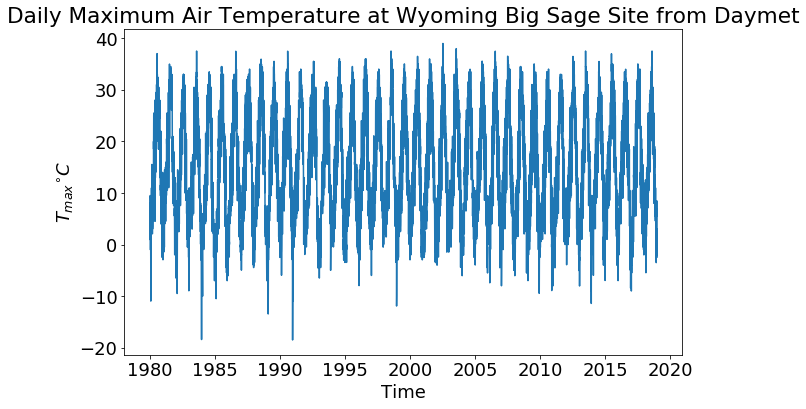

In [6]:
Tmax = dsloc['tmax'].values
time = dsloc['time'].values

register_matplotlib_converters() # Needed to avoid a matplotlib warning

plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 12})
plt.plot(time, Tmax)
plt.title('Daily Maximum Air Temperature at Wyoming Big Sage Site from Daymet')
plt.xlabel('Time')
plt.ylabel('$T_{max} {}^{\circ}C$')
plt.show()